In [1]:
using DifferentialEquations
using Plots
using Roots
using Plots.PlotMeasures
using PlotUtils
using BSON

In [2]:
function swing_rhs(du,u,p,t)
    du[1] = u[2]
    du[2] = p[1] - p[2] * u[2] + p[3] * sin(u[1])
end

swing_rhs (generic function with 1 method)

In [3]:
function final_freq(u0, du0, p, max_t)
    swing = ODEProblem(swing_rhs, [u0, du0], (0.,max_t), p)
    sol = solve(swing, Vern7(), reltol=1e-10,abstol=1e-10)
    sol[end][2]
end

final_freq (generic function with 1 method)

In [4]:
function basin_data(max_y, pars; res=0.1, max_t=1000., data=nothing)
        x = 0.:res:2*pi
        y = -1. * max_y:res:max_y
        X = repeat(reshape(x, 1, :), length(y), 1)
        Y = repeat(y, 1, length(x));

        Z = map(tup -> final_freq(tup[1], tup[2], pars, max_t), zip(X,Y));

        Z2 = map(z -> z < 0.1 ? 1 : 0, Z);
        
        x, y, Z, Z2, max_y, pars, res
end

basin_data (generic function with 1 method)

In [5]:
function basin_plot(data; no_lc=false)
    x, y, Z, Z2, max_y, pars, res = data
    
    plt = heatmap(x,y,Z2,
                colorbar=false,
                color=:heat,
                xtickfontsize=24,ytickfontsize=24,
                xticks=([0.,pi,2pi],["0","\\pi","2\\pi"]), xlims=(0.,2pi), ylims=(-max_y, max_y),
                right_margin = 5mm,
                clim=(0,1))
    
    # Plot the fixpoints
    if pars[1] < pars[3]
        ϕ = (asin(-1. * pars[1]/pars[3]))
        scatter!(plt,[ϕ, pi - ϕ]  .|> mod2pi , [0., 0.], legend = false, color=:white, marker=(:dot, 5, Plots.stroke(2, :black)))
    end
        
    if no_lc
        return plt
    end
    
    # Plot the limit cycle
    swing = ODEProblem(swing_rhs, [0., pars[1]/pars[2]], (0.,1000.), pars)
    sol = solve(swing, BS5());
    
    f1 = t -> sol(1000. - t)[1]
    f2 = t -> sol(1000. - t)[2]
    
    g = t -> f1(t) - floor(f1(0.) / 2pi) * 2pi
    g2 = t -> f1(t) - (floor(f1(0.) / 2pi) - 1.) * 2pi
    
    lc_ts = (find_zero(g,(0.,10.)), find_zero(g2,(0.,10.)))
    
    lc_step = (lc_ts[2] - lc_ts[1]) * res * 0.1
    lc_t = collect(lc_ts[1]:lc_step:lc_ts[2]) 
    
    x_lc = map(t -> f1(t) |> mod2pi, lc_t)
    y_lc = map(f2, lc_t)
    
    plot!(plt, x_lc[2:end-1], y_lc[2:end-1], linecolor=:black, linewidth=4, legend=false)
end

basin_plot (generic function with 1 method)

In [6]:
res = 1.

data = basin_data(33.,(1., 0.3, 8.), res=res, max_t=1000.)
bson("data_1.bson", data = data)
println("First set calculated")

data = basin_data(33.,(2., 0.3, 8.), res=res, max_t=1000.)
bson("data_2.bson", data = data)
println("Second set calculated")


data = basin_data(33.,(4., 0.3, 8.), res=res, max_t=1000.)
bson("data_3.bson", data = data)
println("Third set calculated")


data = basin_data(33.,(9., 0.3, 8.), res=res, max_t=1000.)
bson("data_4.bson", data = data);
println("Fourth set calculated, plotting...")


First set calculated
Second set calculated
Third set calculated
Fourth set calculated, plotting...


In [6]:
plt1 = basin_plot(BSON.load("data_1.bson")[:data], no_lc = true);
plt2 = basin_plot(BSON.load("data_2.bson")[:data], no_lc = false);
plt3 = basin_plot(BSON.load("data_3.bson")[:data], no_lc = false);
plt4 = basin_plot(BSON.load("data_4.bson")[:data], no_lc = false);

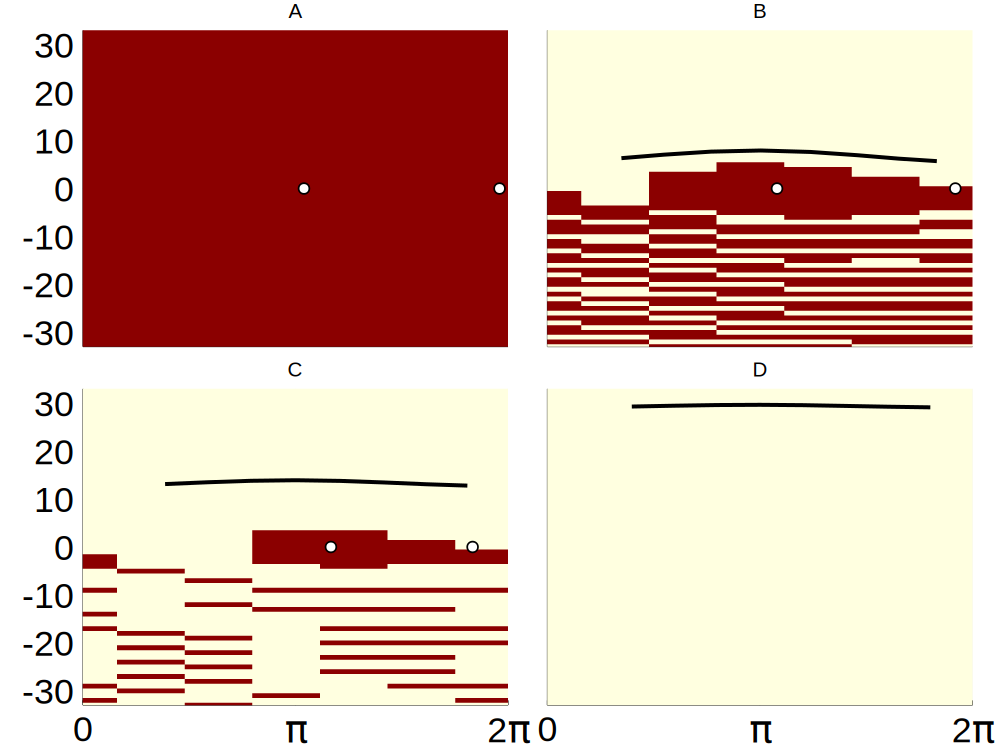

In [7]:
plot!(plt2, xticks=false, yticks=false)
plot!(plt1, xticks=false)
plot!(plt4, yticks=false)
plt_all = plot(plt1, plt2, plt3, plt4, title=["A" "B" "C" "D"], size=(1000,750))

In [9]:
savefig(plt_all, "phase_space.svg")